# Automatic emittance measurement at LCLS-II
In this case we have 4 quadrupoles, 3 that are used to minimize the incoming beam and
 the fourth to perform the quad scan measurement.

In [1]:
# optionally add scripts location to path
if True:
    import sys
    sys.path.append("../../")
    sys.path.append("../")

run_dir = "/home/physics3/ml_tuning/20230818_LCLS_optimize/"
print(sys.path)

['/home/physics3/rroussel/SLAC_Xopt/lcls/optimization', '/usr/local/lcls/tools/python/toolbox', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python39.zip', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/lib-dynload', '', '/home/physics3/.local/lib/python3.9/site-packages', '/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages', '../../', '../']


## Set up image diagnostic

In [2]:
from scripts.image import ImageDiagnostic
import yaml

fname = "../OTR3_config.yml"
image_diagnostic = ImageDiagnostic.parse_obj(yaml.safe_load(open(fname)))
image_diagnostic.save_image_location = run_dir
image_diagnostic.n_fitting_restarts = 2
image_diagnostic.visualize = False
image_diagnostic.background_file = run_dir + "OTRS_IN20_621_background.npy"
print(image_diagnostic.yaml())

{screen_name: 'OTRS:IN20:621', array_data_suffix: IMAGE, array_n_cols: ROI_XNP, array_n_rows: ROI_YNP,
  resolution: RESOLUTION, background_file: /home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy,
  save_image_location: /home/physics3/ml_tuning/20230818_LCLS_optimize/, roi: null,
  min_log_intensity: 4.0, bounding_box_half_width: 3.0, wait_time: 0.1, n_fitting_restarts: 2,
  visualize: false, testing: false}



In [3]:
#image_diagnostic.measure_background(file_location=run_dir)

In [4]:
image_diagnostic.background_file

'/home/physics3/ml_tuning/20230818_LCLS_optimize/OTRS_IN20_621_background.npy'

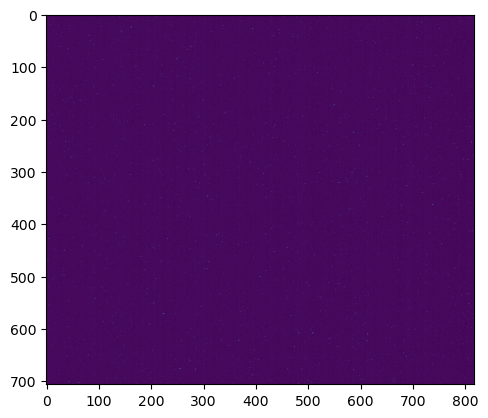

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image_diagnostic.background_image)

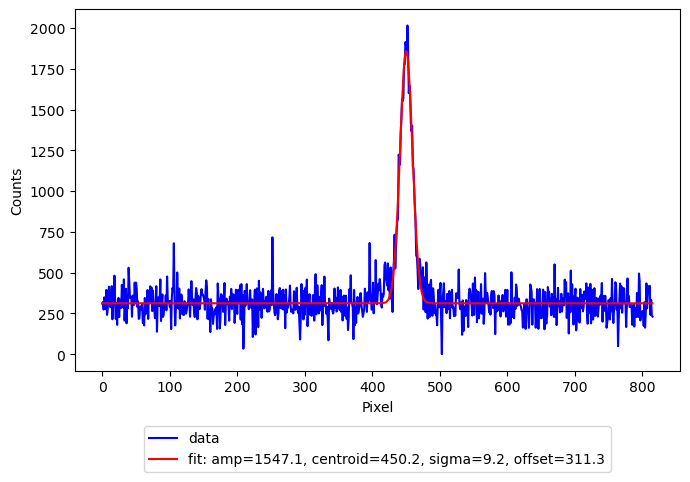

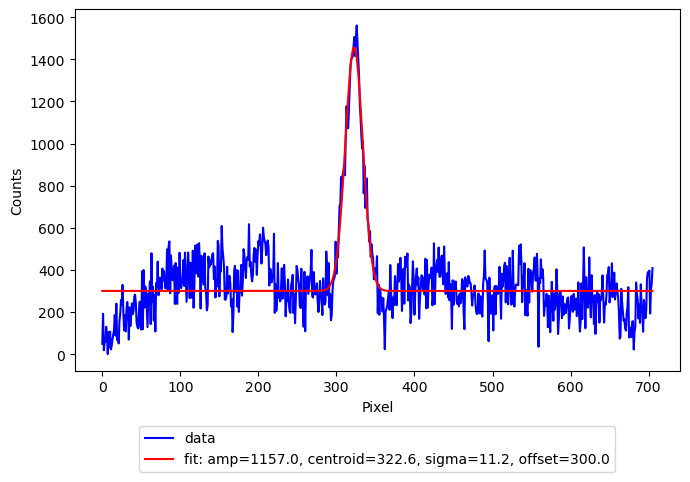

{'Cx': 450.2392966974468,
 'Cy': 322.63345534540537,
 'Sx': 111.23037281006266,
 'Sy': 135.5647897150909,
 'bb_penalty': -180.6328621065494,
 'total_intensity': 1048526.7999999999,
 'log10_total_intensity': 6.0205795353672835}

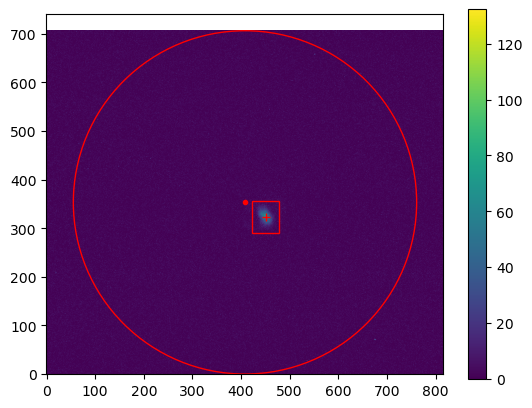

In [6]:
image_diagnostic.test_measurement()

In [7]:
import pandas as pd
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')

In [8]:
IMAGE_CONSTRAINTS = {
            "bb_penalty": ["LESS_THAN", 0.0],
            "log10_total_intensity": ["GREATER_THAN", image_diagnostic.min_log_intensity]
        }

from xopt import VOCS
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL","QUAD:IN20:122:BCTRL",'QUAD:IN20:361:BCTRL','QUAD:IN20:371:BCTRL','QUAD:IN20:425:BCTRL','QUAD:IN20:441:BCTRL','QUAD:IN20:511:BCTRL','QUAD:IN20:525:BCTRL']
vocs = VOCS(
        variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
        constraints = IMAGE_CONSTRAINTS,
        objectives = {"total_size": "MINIMIZE"},
    )
print(vocs)

variables={'SOLN:IN20:121:BCTRL': [0.377, 0.498], 'QUAD:IN20:121:BCTRL': [-0.021, 0.021], 'QUAD:IN20:122:BCTRL': [-0.021, 0.021], 'QUAD:IN20:361:BCTRL': [-4.32, -1.08], 'QUAD:IN20:371:BCTRL': [1.09, 4.31], 'QUAD:IN20:425:BCTRL': [-7.56, -1.08], 'QUAD:IN20:441:BCTRL': [-1.08, 7.56], 'QUAD:IN20:511:BCTRL': [-1.08, 7.56], 'QUAD:IN20:525:BCTRL': [-7.56, -1.08]} constraints={'bb_penalty': ['LESS_THAN', 0.0], 'log10_total_intensity': ['GREATER_THAN', 4.0]} objectives={'total_size': 'MINIMIZE'} constants={} observables=[]


In [9]:
from epics import caput, caget_many
from time import sleep
import numpy as np
def eval_beamsize(inputs):
        # set PVs
        for k, v in inputs.items():
            print(f'CAPUT {k} {v}')
            caput(k, v)

        sleep(2.0)

        # get beam sizes from image diagnostic
        results = image_diagnostic.measure_beamsize(5, **inputs)
        results["S_x_mm"] = np.array(results["Sx"]) * 1e-3
        results["S_y_mm"] = np.array(results["Sy"]) * 1e-3

        # get other PV's NOTE: Measurements not synchronous with beamsize measurements!
        results = results

        # add total beam size
        results["total_size"] = np.sqrt(np.array(results["Sx"]) ** 2 + np.array(results["Sy"]) ** 2)
        return results

In [11]:
from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import BayesianExplorationGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor

# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(use_low_noise_prior=False)
generator = BayesianExplorationGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    turbo_controller="safety"
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.options.dump_file = "be_results.yml"
X


            Xopt
________________________________
Version: 2.0a1+63.g53057de
Data size: 0
Config as YAML:
xopt: {asynch: false, strict: true, dump_file: be_results.yml, max_evaluations: null}
generator:
  name: bayesian_exploration
  model: null
  turbo_controller:
    dim: 9
    batch_size: 1
    length: 0.25
    length_min: 0.0078125
    length_max: 2.0
    failure_counter: 0
    failure_tolerance: 5
    success_counter: 0
    success_tolerance: 5
    center_x: null
    scale_factor: 1.25
    tkwargs: {dtype: torch.float64}
    min_feasible_fraction: 0.75
  use_cuda: false
  model_constructor:
    name: standard
    use_low_noise_prior: false
    covar_modules: {}
    mean_modules: {}
    trainable_mean_keys: []
  numerical_optimizer: {name: LBFGS, n_raw_samples: 20, n_restarts: 20, max_iter: 200}
  max_travel_distances: null
  fixed_features: null
  n_monte_carlo_samples: 128
evaluator:
  function: __main__.eval_beamsize
  max_workers: 1
  function_kwargs: {}
  vectorized: false
vo

In [12]:
default = {'SOLN:IN20:121:BCTRL': 0.4726221999999998,
 'QUAD:IN20:121:BCTRL': -0.0048398437,
 'QUAD:IN20:122:BCTRL': 0.0018000000000000004,
 'QUAD:IN20:361:BCTRL': -3.16,
 'QUAD:IN20:371:BCTRL': 2.5352702,
 'QUAD:IN20:425:BCTRL': -1.5,
 'QUAD:IN20:441:BCTRL': -0.8118599,
 'QUAD:IN20:511:BCTRL': 3.6494056,
 'QUAD:IN20:525:BCTRL': -3.2522187}

In [13]:
import pandas as pd
X.evaluate_data(pd.DataFrame(default, index=[0]))

CAPUT SOLN:IN20:121:BCTRL 0.4726221999999998
CAPUT QUAD:IN20:121:BCTRL -0.0048398437
CAPUT QUAD:IN20:122:BCTRL 0.0018000000000000004
CAPUT QUAD:IN20:361:BCTRL -3.16
CAPUT QUAD:IN20:371:BCTRL 2.5352702
CAPUT QUAD:IN20:425:BCTRL -1.5
CAPUT QUAD:IN20:441:BCTRL -0.8118599
CAPUT QUAD:IN20:511:BCTRL 3.6494056
CAPUT QUAD:IN20:525:BCTRL -3.2522187


,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,378.573922,...,223.704114,-212.105127,1042851.6,6.018223,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.02424,0.223704,225.013573,6.839585,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.760506,...,223.697291,-193.709439,1042851.6,6.018223,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.068604,0.223697,233.980865,6.839585,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.085893,...,212.930406,-195.70936,1052382.0,6.022173,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.071633,0.21293,224.656654,6.839585,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,528.709994,...,211.262295,-125.401174,1059777.4,6.025215,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.02424,0.211262,212.648383,6.839585,False
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,415.577166,...,226.980416,-192.646741,1074235.4,6.031099,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.068733,0.22698,237.158786,6.839585,False


In [14]:
X.data

,SOLN:IN20:121:BCTRL,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,Cx,...,Sy,bb_penalty,total_intensity,log10_total_intensity,save_filename,S_x_mm,S_y_mm,total_size,xopt_runtime,xopt_error
1,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,378.573922,...,223.704114,-212.105127,1042851.6,6.018223,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.02424,0.223704,225.013573,6.839585,False
2,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.760506,...,223.697291,-193.709439,1042851.6,6.018223,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.068604,0.223697,233.980865,6.839585,False
3,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,416.085893,...,212.930406,-195.70936,1052382.0,6.022173,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.071633,0.21293,224.656654,6.839585,False
4,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,528.709994,...,211.262295,-125.401174,1059777.4,6.025215,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.02424,0.211262,212.648383,6.839585,False
5,0.472622,-0.00484,0.0018,-3.16,2.53527,-1.5,-0.81186,3.649406,-3.252219,415.577166,...,226.980416,-192.646741,1074235.4,6.031099,/home/physics3/ml_tuning/20230818_LCLS_optimiz...,0.068733,0.22698,237.158786,6.839585,False


In [ ]:
for i in range(100):
    print(i)
    X.step()

0
CAPUT QUAD:IN20:121:BCTRL -0.0100898437
CAPUT QUAD:IN20:122:BCTRL 0.007050000000000001
CAPUT QUAD:IN20:361:BCTRL -3.5650000000000004
CAPUT QUAD:IN20:371:BCTRL 2.9377701999999997
CAPUT QUAD:IN20:425:BCTRL -2.31
CAPUT QUAD:IN20:441:BCTRL 0.2681401000000001
CAPUT QUAD:IN20:511:BCTRL 4.7294056
CAPUT QUAD:IN20:525:BCTRL -2.4422186999999993
CAPUT SOLN:IN20:121:BCTRL 0.4877471999999998
1


/usr/local/lcls/package/anaconda/envs/rhel7_devel/lib/python3.9/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


CAPUT QUAD:IN20:121:BCTRL -0.001923176989210464
CAPUT QUAD:IN20:122:BCTRL -0.0011166667107895597
CAPUT QUAD:IN20:361:BCTRL -3.744999981186693
CAPUT QUAD:IN20:371:BCTRL 2.311659072829981
CAPUT QUAD:IN20:425:BCTRL -2.6699999986991205
CAPUT QUAD:IN20:441:BCTRL -1.0644339152052122
CAPUT QUAD:IN20:511:BCTRL 5.072839881273576
CAPUT QUAD:IN20:525:BCTRL -3.70221869869912
CAPUT SOLN:IN20:121:BCTRL 0.4642194216018443
2
CAPUT QUAD:IN20:121:BCTRL -0.012423177077456202
CAPUT QUAD:IN20:122:BCTRL 0.009383333377456227
CAPUT QUAD:IN20:361:BCTRL -2.9350000188133074
CAPUT QUAD:IN20:371:BCTRL 3.1166591049477965
CAPUT QUAD:IN20:425:BCTRL -1.08
CAPUT QUAD:IN20:441:BCTRL 0.05705683108661794
CAPUT QUAD:IN20:511:BCTRL 3.0494056259516853
CAPUT QUAD:IN20:525:BCTRL -2.082218701300878
CAPUT SOLN:IN20:121:BCTRL 0.4642194216018443
3
CAPUT QUAD:IN20:121:BCTRL -0.002953368566334138
CAPUT QUAD:IN20:122:BCTRL -8.647513366585695e-05
CAPUT QUAD:IN20:361:BCTRL -2.858166277311069
CAPUT QUAD:IN20:371:BCTRL 3.1840413755393024

In [ ]:
X.data.plot(y="total_size")

In [ ]:
X.data.plot(y=X.vocs.variable_names)

In [ ]:
X.data.head()["total_size"].mean()

In [ ]:
X.data.tail()["total_size"].mean()

In [ ]:
X.data["total_size"].min()